In [10]:
# ===========================================
# Cell 1 — Imports & Config (Improved Ensemble)
# ===========================================
import os, random, math, numpy as np, pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import timm

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix,
    classification_report, matthews_corrcoef, precision_recall_curve, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt

# Repro
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ---- Paths (edit if needed) ----
CSV_PATH = "yolo_crops.csv"        # your CSV
ROOT_DIR = "./"                    # base path of images
CKPT_RESNET50 = "resnet50_cbis.pt" # your trained ResNet50 checkpoint
CKPT_EFFNETV2 = "effnetv2_b3_imbalance.pt"  # your trained EffNetV2-B3 checkpoint

# ---- Data / Loader ----
IMG_SIZE = 512
BATCH_SIZE = 32  # increase a bit for faster eval
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

# ---- TTA ----
USE_TTA = False   # set True to enable simple TTA (hflip)
TTA_PASSES = 4    # number of extra augmented passes if USE_TTA

# ---- Threshold sweep space ----
THRESH_GRID = np.linspace(0.20, 0.80, 61)  # for F1 optimization


In [11]:
# ===========================================
# Cell 2 — Load CSV & Preprocessing (Eval only)
# ===========================================
df = pd.read_csv(CSV_PATH)
df["exists"] = df["yolo_cropped_image_path"].apply(
    lambda rel: os.path.exists(os.path.join(ROOT_DIR, str(rel).replace("\\", os.sep)))
)
df = df[df["exists"]].copy()
df["label"] = df["label"].astype(int)

print("Samples:", len(df),
      "| Malignant:", int((df["label"]==1).sum()),
      "| Benign:", int((df["label"]==0).sum()))

# Evaluation transforms (deterministic & fast)
val_tf = A.Compose([
    A.CLAHE(clip_limit=3.0, tile_grid_size=(8,8), p=1.0),
    A.Resize(height=IMG_SIZE, width=IMG_SIZE),
    A.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ToTensorV2(),
])


Samples: 1354 | Malignant: 326 | Benign: 1028


In [12]:
# ===========================================
# Cell 3 — Dataset & DataLoaders (Eval split)
# ===========================================
class CropsDataset(Dataset):
    def __init__(self, df, root=ROOT_DIR, tf=None):
        self.df, self.root, self.tf = df.reset_index(drop=True), root, tf
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        row = self.df.iloc[i]
        p = os.path.join(self.root, str(row["yolo_cropped_image_path"]).replace("\\", os.sep))
        im = Image.open(p).convert("L")
        arr = np.stack([np.array(im)]*3, axis=2).astype(np.uint8)  # gray → 3ch
        x = self.tf(image=arr)["image"]
        y = torch.tensor(int(row["label"]), dtype=torch.float32)
        return x, y

# Use the same 80/20 split seed you trained with (to compare apples to apples)
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=SEED)
val_ds = CropsDataset(val_df, tf=val_tf)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Peek a batch
xb, yb = next(iter(val_loader))
print("Val batch:", xb.shape, yb.shape)


Val batch: torch.Size([32, 3, 512, 512]) torch.Size([32])


In [13]:
# ===========================================
# Cell 4 — Model Builders & Robust Checkpoint Loader
# ===========================================
def make_resnet50():
    m = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2)
    in_feat = m.fc.in_features
    m.fc = nn.Linear(in_feat, 1)  # will adjust if checkpoint uses Sequential head
    return m

def make_effnetv2_b3():
    return timm.create_model("tf_efficientnetv2_b3", pretrained=True, in_chans=3, num_classes=1)

def load_ckpt(model, ckpt_path, model_name="model"):
    if not os.path.exists(ckpt_path):
        print(f"[WARN] Checkpoint not found: {ckpt_path} — using ImageNet weights only.")
        return model
    ckpt = torch.load(ckpt_path, map_location=DEVICE)
    state = ckpt.get("model", ckpt)

    if isinstance(model, torchvision.models.ResNet):
        keys = list(state.keys())
        has_seq_head = any(k.startswith("fc.1.") for k in keys)   # Sequential(Dropout, Linear)
        has_linear   = any(k.startswith("fc.weight") for k in keys)

        if has_seq_head:
            in_feat = model.fc.in_features
            model.fc = nn.Sequential(nn.Dropout(0.3), nn.Linear(in_feat, 1)).to(DEVICE)
            try:
                model.load_state_dict(state, strict=True)
                print("[OK] ResNet50: loaded checkpoint with Sequential head.")
                return model
            except Exception as e:
                print(f"[WARN] Strict load failed (seq), using non-strict: {e}")
                model.load_state_dict(state, strict=False)
                return model

        if has_linear:
            in_feat = model.fc.in_features
            model.fc = nn.Linear(in_feat, 1).to(DEVICE)
            try:
                model.load_state_dict(state, strict=True)
                print("[OK] ResNet50: loaded checkpoint with Linear head.")
                return model
            except Exception as e:
                print(f"[WARN] Strict load failed (linear), using non-strict: {e}")
                model.load_state_dict(state, strict=False)
                return model

        print("[INFO] ResNet50: head pattern unknown; non-strict load.")
        model.load_state_dict(state, strict=False)
        return model
    else:
        try:
            model.load_state_dict(state, strict=True)
            print(f"[OK] {model_name}: loaded checkpoint (strict).")
        except Exception as e:
            print(f"[WARN] {model_name}: strict load failed, non-strict: {e}")
            model.load_state_dict(state, strict=False)
        return model

# Build & load
resnet50 = make_resnet50().to(DEVICE)
effnetv2 = make_effnetv2_b3().to(DEVICE)
resnet50 = load_ckpt(resnet50, CKPT_RESNET50, "ResNet50")
effnetv2 = load_ckpt(effnetv2, CKPT_EFFNETV2, "EffNetV2-B3")

resnet50.eval(); effnetv2.eval()

# Sanity forward
with torch.no_grad():
    o1 = resnet50(xb.to(DEVICE))
    o2 = effnetv2(xb.to(DEVICE))
print("ResNet50 out:", tuple(o1.shape), "| EffNetV2-B3 out:", tuple(o2.shape))


[OK] ResNet50: loaded checkpoint with Sequential head.
[OK] EffNetV2-B3: loaded checkpoint (strict).
ResNet50 out: (32, 1) | EffNetV2-B3 out: (32, 1)


In [14]:
# ===========================================
# Cell 5 — Prediction Utilities (single, TTA, metrics)
# ===========================================
@torch.no_grad()
def predict_proba_single(model, loader, device=DEVICE, tta=False, tta_passes=4):
    model.eval()
    y_true, y_prob = [], []
    for x, y in loader:
        x = x.to(device)
        # base pass
        p = torch.sigmoid(model(x)).squeeze(1).cpu().numpy()

        if tta:
            # simple TTA: horizontal flip passes
            acc = p.copy()
            for _ in range(tta_passes):
                x_aug = torch.flip(x, dims=[3])
                p_aug = torch.sigmoid(model(x_aug)).squeeze(1).cpu().numpy()
                acc += p_aug
            p = acc / (tta_passes + 1)

        y_prob.extend(p.tolist())
        y_true.extend(y.numpy().tolist())
    return np.array(y_true, dtype=int), np.array(y_prob, dtype=float)

def compute_full_metrics(y_true, y_prob, threshold=None, ts_grid=THRESH_GRID):
    if threshold is None:
        f1s = [f1_score(y_true, (y_prob >= t).astype(int)) for t in ts_grid]
        threshold = float(ts_grid[int(np.argmax(f1s))])
    yp = (y_prob >= threshold).astype(int)

    acc = accuracy_score(y_true, yp)
    f1  = f1_score(y_true, yp)
    auc = roc_auc_score(y_true, y_prob)
    cm  = confusion_matrix(y_true, yp)
    tn, fp, fn, tp = cm.ravel()
    sens = tp / (tp + fn + 1e-8)
    spec = tn / (tn + fp + 1e-8)
    prec = tp / (tp + fp + 1e-8)
    npv  = tn / (tn + fn + 1e-8)
    bal  = 0.5*(sens + spec)
    mcc  = matthews_corrcoef(y_true, yp)
    return {
        "threshold": threshold, "acc": acc, "f1": f1, "auc": auc,
        "sensitivity": sens, "specificity": spec, "precision": prec, "npv": npv,
        "balanced_acc": bal, "mcc": mcc, "cm": cm
    }


In [15]:
# ===========================================
# Cell 6 — Get Per-Model Validation Probabilities
# ===========================================
y_true_r, y_prob_r = predict_proba_single(resnet50, val_loader, tta=USE_TTA, tta_passes=TTA_PASSES)
y_true_e, y_prob_e = predict_proba_single(effnetv2, val_loader, tta=USE_TTA, tta_passes=TTA_PASSES)

# Sanity: truths must match
assert np.array_equal(y_true_r, y_true_e)
y_true = y_true_r

# Single-model metrics
m_r = compute_full_metrics(y_true, y_prob_r, threshold=None)
m_e = compute_full_metrics(y_true, y_prob_e, threshold=None)

print("=== SINGLE MODELS (auto-F1 threshold) ===")
print(f"ResNet50 — AUC={m_r['auc']:.4f} | F1={m_r['f1']:.4f} | Acc={m_r['acc']:.4f} | Thr={m_r['threshold']:.3f}")
print(f"EffNetV2 — AUC={m_e['auc']:.4f} | F1={m_e['f1']:.4f} | Acc={m_e['acc']:.4f} | Thr={m_e['threshold']:.3f}")


=== SINGLE MODELS (auto-F1 threshold) ===
ResNet50 — AUC=0.8293 | F1=0.6259 | Acc=0.7970 | Thr=0.540
EffNetV2 — AUC=0.8184 | F1=0.5921 | Acc=0.7712 | Thr=0.610


In [16]:
# ===========================================
# Cell 7 — Weighted Ensemble: Grid-Search Weights + Threshold
# ===========================================
def weighted_ensemble_probs(p1, p2, w1):
    # w1 for model1, (1-w1) for model2
    return w1 * p1 + (1.0 - w1) * p2

best = {"f1": -1}
for w in np.linspace(0.0, 1.0, 21):  # 0.00, 0.05, ..., 1.00
    p_ens = weighted_ensemble_probs(y_prob_r, y_prob_e, w)
    # find best threshold for F1
    f1s = [f1_score(y_true, (p_ens >= t).astype(int)) for t in THRESH_GRID]
    idx = int(np.argmax(f1s))
    f1 = f1s[idx]
    t  = float(THRESH_GRID[idx])
    if f1 > best["f1"]:
        m = compute_full_metrics(y_true, p_ens, threshold=t)
        best = {"w": float(w), "thr": t, **m}

print("=== WEIGHTED ENSEMBLE (grid-searched) ===")
print(f"Weight ResNet50 : {best['w']:.2f}  | Weight EffNetV2 : {1.0 - best['w']:.2f}")
print(f"Threshold       : {best['thr']:.3f}")
print(f"AUC             : {best['auc']:.4f}")
print(f"Accuracy        : {best['acc']:.4f}")
print(f"Balanced Acc    : {best['balanced_acc']:.4f}")
print(f"Sensitivity     : {best['sensitivity']:.4f}")
print(f"Specificity     : {best['specificity']:.4f}")
print(f"Precision       : {best['precision']:.4f}")
print(f"F1              : {best['f1']:.4f}")
print(f"MCC             : {best['mcc']:.4f}")
print("Confusion matrix [[TN FP] [FN TP]]:\n", best["cm"])


=== WEIGHTED ENSEMBLE (grid-searched) ===
Weight ResNet50 : 0.55  | Weight EffNetV2 : 0.45
Threshold       : 0.570
AUC             : 0.8527
Accuracy        : 0.8229
Balanced Acc    : 0.7993
Sensitivity     : 0.7538
Specificity     : 0.8447
Precision       : 0.6049
F1              : 0.6712
MCC             : 0.5583
Confusion matrix [[TN FP] [FN TP]]:
 [[174  32]
 [ 16  49]]


In [17]:
# ===========================================
# Cell 8 — Stacking Meta-Classifier (Logistic Regression)
# ===========================================
# Features: per-model probabilities + their average & difference (simple but effective)
X_full = np.stack([y_prob_r, y_prob_e,
                   0.5*(y_prob_r+y_prob_e),
                   (y_prob_r - y_prob_e)], axis=1)
y_full = y_true.copy()

# Split the validation set into meta-train/meta-test (50/50 stratified) to avoid overfitting
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=SEED)
(train_idx, test_idx) = next(sss.split(X_full, y_full))

X_meta_tr, y_meta_tr = X_full[train_idx], y_full[train_idx]
X_meta_te, y_meta_te = X_full[test_idx], y_full[test_idx]

# Stacking model: Logistic Regression with class_weight to handle imbalance
meta = LogisticRegression(
    penalty="l2", C=1.0, max_iter=1000, class_weight="balanced", solver="liblinear"
)
meta.fit(X_meta_tr, y_meta_tr)

# Predict proba on meta-test; use column 1 as malignant probability
p_meta = meta.predict_proba(X_meta_te)[:, 1]

# Optimize threshold for F1 on meta-test
f1s = [f1_score(y_meta_te, (p_meta >= t).astype(int)) for t in THRESH_GRID]
t_meta = float(THRESH_GRID[int(np.argmax(f1s))])
m_meta = compute_full_metrics(y_meta_te, p_meta, threshold=t_meta)

print("=== STACKING (Logistic Regression, meta-test split) ===")
print(f"Optimal threshold : {m_meta['threshold']:.3f}")
print(f"AUC               : {m_meta['auc']:.4f}")
print(f"Accuracy          : {m_meta['acc']:.4f}")
print(f"Balanced Acc      : {m_meta['balanced_acc']:.4f}")
print(f"Sensitivity       : {m_meta['sensitivity']:.4f}")
print(f"Specificity       : {m_meta['specificity']:.4f}")
print(f"Precision         : {m_meta['precision']:.4f}")
print(f"F1                : {m_meta['f1']:.4f}")
print(f"MCC               : {m_meta['mcc']:.4f}")
print("Confusion matrix [[TN FP] [FN TP]]:\n", m_meta["cm"])

# Optional: evaluate the same trained meta on the *entire* val set (may overfit; just for reference)
p_meta_full = meta.predict_proba(X_full)[:, 1]
m_meta_full = compute_full_metrics(y_full, p_meta_full, threshold=None)
print("\n[Ref] STACKING on full val (reference only, can overfit):")
print(f"AUC={m_meta_full['auc']:.4f} | F1={m_meta_full['f1']:.4f} | Acc={m_meta_full['acc']:.4f} | Thr={m_meta_full['threshold']:.3f}")


=== STACKING (Logistic Regression, meta-test split) ===
Optimal threshold : 0.550
AUC               : 0.8182
Accuracy          : 0.7941
Balanced Acc      : 0.7817
Sensitivity       : 0.7576
Specificity       : 0.8058
Precision         : 0.5556
F1                : 0.6410
MCC               : 0.5133
Confusion matrix [[TN FP] [FN TP]]:
 [[83 20]
 [ 8 25]]

[Ref] STACKING on full val (reference only, can overfit):
AUC=0.8524 | F1=0.6667 | Acc=0.8192 | Thr=0.590


                    name      auc       f1      acc  bal_acc     sens     spec     prec      mcc  thr
       ResNet50 (single) 0.829276 0.625850 0.797048 0.766468 0.707692 0.825243 0.560976 0.495367 0.54
    EffNetV2-B3 (single) 0.818372 0.592105 0.771218 0.744212 0.692308 0.796117 0.517241 0.446703 0.61
  Weighted Ens (wR=0.55) 0.852651 0.671233 0.822878 0.799253 0.753846 0.844660 0.604938 0.558264 0.57
    Stacking (meta-test) 0.818182 0.641026 0.794118 0.781700 0.757576 0.805825 0.555556 0.513294 0.55
Stacking (full-val, ref) 0.852353 0.666667 0.819188 0.796826 0.753846 0.839806 0.597561 0.551803 0.59


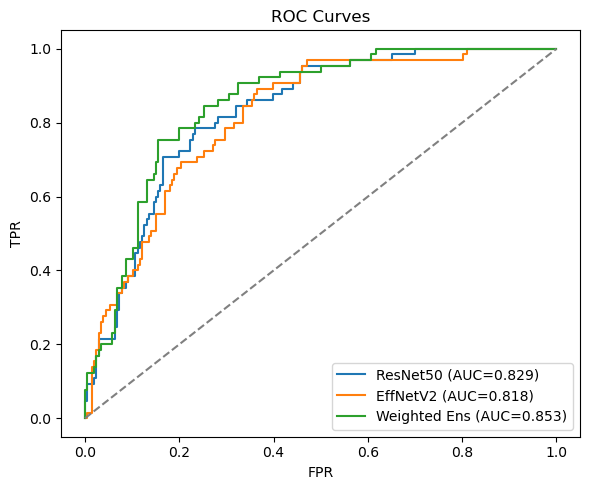

In [18]:
# ===========================================
# Cell 9 — Curves & Comparison Table
# ===========================================
def summarize(name, m):
    tn, fp, fn, tp = m["cm"].ravel()
    return {
        "name": name,
        "thr": m["threshold"], "acc": m["acc"], "bal_acc": m["balanced_acc"],
        "sens": m["sensitivity"], "spec": m["specificity"],
        "prec": m["precision"], "f1": m["f1"], "auc": m["auc"], "mcc": m["mcc"],
        "tn": tn, "fp": fp, "fn": fn, "tp": tp
    }

# Build comparison rows
rows = [
    summarize("ResNet50 (single)", m_r),
    summarize("EffNetV2-B3 (single)", m_e),
    summarize(f"Weighted Ens (wR={best['w']:.2f})", best),
    summarize("Stacking (meta-test)", m_meta),
    summarize("Stacking (full-val, ref)", m_meta_full),
]
df_cmp = pd.DataFrame(rows)
pd.set_option("display.max_colwidth", None)
print(df_cmp[["name","auc","f1","acc","bal_acc","sens","spec","prec","mcc","thr"]].to_string(index=False))

# Optional ROC curves for single vs best weighted ensemble
from sklearn.metrics import roc_curve
fpr_r, tpr_r, _ = roc_curve(y_true, y_prob_r)
fpr_e, tpr_e, _ = roc_curve(y_true, y_prob_e)
p_best = weighted_ensemble_probs(y_prob_r, y_prob_e, best["w"])
fpr_w, tpr_w, _ = roc_curve(y_true, p_best)

plt.figure(figsize=(6,5))
plt.plot(fpr_r, tpr_r, label=f"ResNet50 (AUC={m_r['auc']:.3f})")
plt.plot(fpr_e, tpr_e, label=f"EffNetV2 (AUC={m_e['auc']:.3f})")
plt.plot(fpr_w, tpr_w, label=f"Weighted Ens (AUC={best['auc']:.3f})")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curves")
plt.legend(); plt.tight_layout(); plt.show()
